In [40]:
import numpy as np
import pandas as pd
import os
print(os.getcwd())

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\matze\Documents\locandis


In [332]:
def load_and_merge_files(path=os.getcwd()):
    '''
        Load all csv files in given directory and merges them
    '''
    #Initializing
    df_list = []
    filelist = os.listdir(path)
    csv_files = []
    dataframe = pd.DataFrame()
    
    #Subsets filelist to csv only
    for file in filelist:
        if file.endswith('.csv'):
            csv_files.append(file)
    
    #read each csv file and append it to the DataFrame
    for csv_file in csv_files:
        
        df_list.append(pd.read_csv('{path}/{filename}'.format(path = path,filename=csv_file),sep=';'))
    
    dataframe = pd.concat(df_list)
    
    
    return dataframe

def typecasting(df,object_cols = [],numeric_cols=[],date_cols=[]):
    '''
        retype columns of a dataframe
    
    '''
    df[object_cols] = df[object_cols].astype('object')
    df[date_cols] = df[date_cols].astype('datetime64[s]')
    df[numeric_cols].apply(pd.to_numeric)
    
    return df

In [333]:
df = load_and_merge_files('./Kassendaten')

In [335]:
##preparation of the dataset
df = (df.rename(str.lower, axis='columns').
      drop(['coupon_menge','coupon_kz','coupon_zeile','coupon_id','coupon_betrag','arthiertyp_id']
            , axis = 'columns').
      pipe(typecasting,date_cols=['bon_beginn','bon_ende'], object_cols=['kl_art_id','wgi_id','wg_id']).
      assign(bon_ende = lambda x: x['bon_ende']-x['bon_beginn']).
      rename(columns={'bon_ende':'bon_duration'})
     )




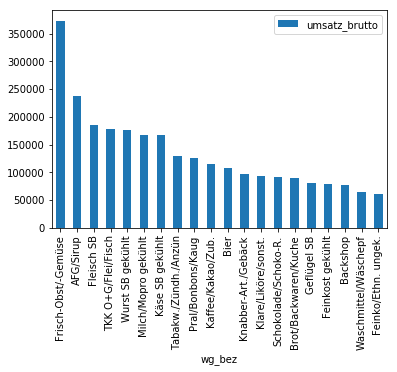

In [450]:
#get top 20 'warengruppe'
top20_wg = (df.groupby(['wg_bez']).
            sum().
            loc[:,['umsatz_brutto']].
            sort_values('umsatz_brutto',ascending=False).
            #reset_index().
            head(20)
           )
top20_wg.plot.bar()


In [351]:
#mittlerer wg-wert wenn auf bon

import time
'''
start=time.time()
avarage_wg_value = (df.groupby('wg_bez').nunique().loc[:,['bon_id']].
                    join(df.groupby('wg_bez').
                         sum().
                         loc[:,['umsatz_brutto']]).
                    rename(columns={'umsatz_brutto':'sum_wg_umsatz','bon_id':'wg_bon_count'}).
                    assign(average_wg_value= lambda x: x['sum_wg_umsatz']/x['wg_bon_count']).
                    loc[:,'average_wg_value'].
                    sort_values(ascending=False)
                    )
print(time.time()-start)
'''

start=time.time()
avarage_wg_value = (df.groupby('wg_bez')['bon_id'].
                    nunique().to_frame().
                    join(df.groupby('wg_bez').
                         sum().
                         loc[:,['umsatz_brutto']]).
                    rename(columns={'umsatz_brutto':'sum_wg_umsatz','bon_id':'wg_bon_count'}).
                    assign(average_wg_value= lambda x: x['sum_wg_umsatz']/x['wg_bon_count']).
                    loc[:,'average_wg_value'].
                    sort_values(ascending=False)
                    )
print(time.time()-start)
###reconsider mittlerwer wg wert wenn er auf einen bon ist summe pro warengruppe plus anzahl der bons auf die er auftaucht
## könnte passen

4.189347982406616


In [180]:
#
#(df.query('umsatz_brutto < 0 & wg_bez != "Pfand"').groupby('bon_id').groups.keys())
#df.loc[df['bon_id'].isin(ind)].astype({'wgi_id':'float64'}).query('wgi_id != -1')
#(df.astype({'wgi_id':'float64'}).
 #query('wgi_id != -1').
# groupby('bon_id').sum().min())

ind = (df.query('umsatz_brutto < 0 & wg_bez != "Pfand"').groupby('bon_id').groups.keys())
df.loc[df['bon_id'].isin(ind)]

(df.query('wg_bez != "Pfand"').nunique())
#minimaler bonwert mit pfand -26.5 ohne pfand 0
#negativer umsatz außerhalb von pfand ist storno und sollte unbedingt drinnen bleiben!

bon_id           2799
bon_zeile         118
bon_beginn       2736
bon_duration      175
umsatz_brutto     911
kl_art_id        7739
wg_id              98
wg_bez             98
wgi_id            558
wgi_bez          2044
dtype: int64

In [108]:
#df.loc[df['wg_bez']== 'Treueprogramm',:]

In [246]:
##list of wg anzahl unique == 1
#wahrscheinlich geht auch max bonzeile NEIN Kann nach filtern von pfdand nicht mehr verwendet werden
ind = df.groupby('bon_id').nunique().filter(['wg_id']).rename(columns={'wg_id':'prod_per_bon'}).query('prod_per_bon == 1').index

df.query('wg_bez != "Pfand"').groupby('bon_id').sum()['umsatz_brutto'].min()
#minimaler bonwert ohne pfand ist 0

0.0

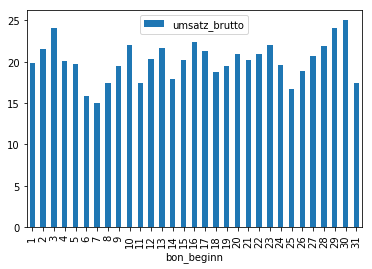

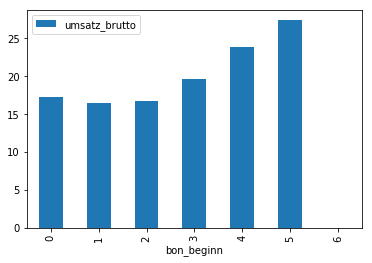

In [443]:
#mittlerer bonwert im verlauf eines Monats
#ist der Mittelwert ller bonwerte uber ein gewisses zeitintervall

avg_bon_value_month= (df.query('wg_bez != "Pfand"').
                      groupby(['bon_beginn','bon_id'])
                      ['umsatz_brutto'].
                      sum().
                      reset_index(1).
                      resample('D').
                      mean().reset_index().
                      assign(bon_beginn = lambda x: x['bon_beginn'].dt.day).
                      groupby('bon_beginn').
                      mean().plot.bar()
                      #rename
)
avg_bon_value_month

avg_bon_value_week= (df.query('wg_bez != "Pfand"').
                      groupby(['bon_beginn','bon_id'])
                      ['umsatz_brutto'].
                      sum().
                      reset_index(1).
                      resample('D').
                      mean().reset_index().
                      assign(bon_beginn = lambda x: x['bon_beginn'].dt.dayofweek).
                      groupby('bon_beginn').
                      mean().plot.bar()
)
avg_bon_value_month


###vergleichen von druchschnitt aller monate mit nur einem vollständigen
###man sieht perioden vermutung weekly

In [397]:
'''
(df.assign(bon_beginn=df['bon_beginn'].dt.day).
 query('wg_bez != "Pfand"').
 groupby(['bon_beginn','bon_id']).
 sum().
 reset_index(1).
 
)
'''


'\n(df.assign(bon_beginn=df[\'bon_beginn\'].dt.day).\n query(\'wg_bez != "Pfand"\').\n groupby([\'bon_beginn\',\'bon_id\']).\n sum().\n reset_index(1).\n \n)\n'

In [ ]:
### werden bestimmte warengruppen besondersoft zu beginn eines monats gekauft
avg_bon_value_month= (df.query('wg_bez != "Pfand"').
                      groupby(['bon_beginn','bon_id'])
                      ['umsatz_brutto'].
                      sum().
                      reset_index(1).
                      resample('D').
                      mean().reset_index().
                      assign(bon_beginn = lambda x: x['bon_beginn'].dt.day).
                      groupby('bon_beginn').
                      mean().plot.bar()
                      #rename
)
avg_bon_value_month

In [528]:
table_wg_count_perday = (df.query('wg_bez != "Pfand" & wg_bez != "Feinkost gek. Theke"').
                         groupby(['wg_bez','bon_beginn'])
                         ['bon_id'].
                         nunique().to_frame().
                         unstack(level=0).
                         resample('D').
                         sum())

#.resample('D',level=1).sum()

In [550]:
exclude =["Pfand","Feinkost gek. Theke","Weihnacht/Halloween","Ostern/Fasching/Pyro","Elektro-Saisonartik.","Sport-Schuhe"]
table=(df.loc[df['wg_bez'].isin(exclude) == False].groupby(['wg_bez','bon_beginn'])
                         ['bon_id'].
                         nunique().to_frame().
                         unstack(level=0).
                         resample('D').
                         sum().apply(lambda x: x/x.sum())
)
#.plot(figsize=(20,10),legend=False)



In [602]:
table2 = (table.reset_index().
 assign(bon_beginn = lambda x: x['bon_beginn'].dt.day).
 assign(beginn = lambda x: pd.cut(x['bon_beginn'],bins=[0,5,31],labels=['beginn','end'])).
 sort_index(axis=1).
 sort_values('bon_beginn').groupby('beginn').sum()
)

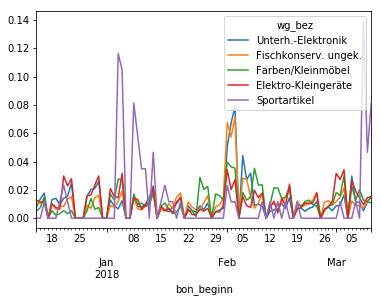

In [842]:
#table2.apply(lambda x: x[0]/x,axis=1)
most_beginn = (table2.loc['beginn']/table2.loc['end']).sort_values(ascending=False).head(5).to_frame().reset_index().wg_bez.values
table.reset_index(col_level=1).T.reset_index(level=0).T.set_index('bon_beginn')
table.T.reset_index(level=0,drop=True).T[most_beginn].plot()
#.reset_index(col_level=1).reset_index(col_level=0)#.reset_index(level=None,col_level='wg_bez')#.reset_index(col_level='wg_bez').T#.reset_index(level='bon_beginn').wg_bez


In [982]:
#### verhältnis am anfang gekaufter werte vs am ende gekaufter werte

exclude =["Pfand","Feinkost gek. Theke","Weihnacht/Halloween","Ostern/Fasching/Pyro","Elektro-Saisonartik.","Sport-Schuhe"]
table=(df.loc[df['wg_bez'].isin(exclude) == False].
       assign(bon_beginn = lambda x: x['bon_beginn'].dt.dayofweek).
       groupby(['wg_bez','bon_beginn'])['bon_id'].
       nunique()
      )

total =  table.sum(level='bon_beginn')

def ratio(df):
     return df.loc['beginn']/df.loc['end']

(table.divide(total,level='bon_beginn').unstack('wg_bez').
 reset_index().
 assign(bon_beginn = lambda x: pd.cut(x['bon_beginn'],bins=[0,1,5],labels=['beginn','end'],include_lowest=True)).
 groupby('bon_beginn').mean().pipe(ratio).sort_values(ascending=False)

)



wg_bez
Kurzwaren/Wolle         1.432415
Nacht-/Unterwäsche      1.369136
Schuhe                  1.355307
Fahrrad-Zubehör         1.306296
Bücher/Brillen          1.260011
Strumpfwaren/Schmuck    1.221634
Lederwaren              1.217972
Heimtextilien           1.199449
Haushaltswaren          1.190768
Preislagen              1.189364
Backshop                1.168215
Schreib-/Büro-/Schul    1.164388
Tchibo-Artikel          1.149460
Fertiggerichte          1.147371
Sportbekleidung         1.145591
Unterh.-Elektronik      1.138969
Autozubehör/Schmier     1.136468
Tabakw./Zündh./Anzün    1.132152
Tee/Instant/Zub.        1.131417
Kaffee/Kakao/Zub.       1.112203
Camping-/Gartenmöbel    1.110975
Waschmittel/Wäschepf    1.099936
Drog/Heilmit/Verband    1.092703
Käse Theke              1.091252
AFG/Sirup               1.083846
Frisch-Obst/-Gemüse     1.082956
Haferfl./Cerealien      1.080684
Milch/Mopro gekühlt     1.080133
Garten                  1.063183
Leuchtmittel/Lampen     1.058008
   

In [500]:
df.query('wg_bez =="Feinkost gek. Theke"')

,bon_id,bon_zeile,bon_beginn,bon_duration,umsatz_brutto,kl_art_id,wg_id,wg_bez,wgi_id,wgi_bez
25543,sbJUX96sGuOhoHGLD9E4+w,16.0,2018-02-26 20:02:16,00:01:26,0.24,1.20132e+06,121,Feinkost gek. Theke,-1,unbek WUG zu WG 121


In [994]:
##an wie vielen Tagen wurden bestimmte warengruppen gekauft
(df.assign(bon_beginn = lambda x: x['bon_beginn'].dt.date).
 groupby('wg_bez')['bon_beginn'].
 nunique().
 sort_values().
 div(df['bon_beginn'].dt.date.nunique())
)
##complete
None

In [1016]:
### anteil der bons mit einem bestimmtem lebensmittel für anfang und ende
total = df.assign(bon_beginn = lambda x: x['bon_beginn'].dt.dayofweek).groupby('bon_beginn')['bon_id'].nunique()
(df.assign(bon_beginn = lambda x: x['bon_beginn'].dt.dayofweek).
 groupby(['bon_beginn','wg_bez'])['bon_id'].nunique().div(total, level='bon_beginn').unstack('wg_bez')
          
)

wg_bez,AFG/Sirup,Autozubehör/Schmier,Backshop,Backzut./Mehl/Gries,Besen/Bürsten,Bier,Brot/Backwaren/Kuche,Butter,Bücher/Brillen,Camping-/Gartenmöbel,...,Unterh.-Elektronik,Waschmittel/Wäschepf,Weihnacht/Halloween,Weinbrand/Rum/Whisky,Weissweine,Wurst SB gekühlt,Wurst SB ungekühlt,Wurst Theke,Würzmittel/Gewürze,Zucker/Salz
bon_beginn,,,,,,,,,,,,,,,,,,,,,
0,0.311926,0.011761,0.248628,0.071252,0.006481,0.088877,0.180016,0.064120,0.005383,0.002435,...,0.011727,0.051125,0.002812,0.012310,0.014367,0.179125,0.043890,0.033192,0.022356,0.039432
1,0.310203,0.012260,0.261739,0.074279,0.005681,0.090854,0.169950,0.061947,0.005249,0.002553,...,0.009707,0.052168,0.003559,0.010031,0.013411,0.170813,0.042604,0.032250,0.024448,0.038865
2,0.310486,0.010965,0.260571,0.073483,0.004942,0.090008,0.178069,0.059089,0.004571,0.002100,...,0.008803,0.044170,0.003459,0.012664,0.014456,0.167104,0.043429,0.030950,0.023660,0.040865
3,0.314827,0.010224,0.252146,0.084659,0.008037,0.098436,0.185720,0.075228,0.005330,0.002324,...,0.010989,0.051528,0.006533,0.012875,0.016046,0.185474,0.047646,0.032776,0.025832,0.047346
4,0.347086,0.013083,0.250245,0.107053,0.008036,0.116955,0.226400,0.093588,0.004903,0.002727,...,0.011959,0.058310,0.006386,0.021932,0.021884,0.232236,0.061395,0.043960,0.032432,0.058430
5,0.386065,0.016366,0.257942,0.121039,0.009367,0.134430,0.254212,0.099371,0.004966,0.003667,...,0.013097,0.071123,0.007775,0.025021,0.025210,0.246710,0.071396,0.040633,0.036505,0.071102


bon_beginn
0    29164
1    27814
2    32375
3    36582
4    41811
5    47720
Name: bon_id, dtype: int64